# SENSITIVITY ANALYSIS
The preliminary results in our IMAGEN paper advocates for a more in-depth understanding of what contributes to the significant performance of the ML models for the three time-points. Here we will throw several what-if questions at the analysis to help us understand better how the ML models worked.

1. Why do the 10 AAM labels have widely different accuracies? 
2. Are all 4 ML models consistent with one another?
3. Are the same subjects mis-predicted at all 3 timepoints?
4. Where the results specifically good for some sites and bad for some others? Across the 4 models? does the finding generalize to holdout?

Two evidence that hints towards the fact that the 'site' confounds may be the reason for the significant accuracy and was not still removed: 
1. Leave-one-site-out CV did not work
2. Performing the chi-squared test between the 2 confounds and the label (c\mapsto y) for all the AAM labels derived show mixed results. <br>
You can see this result in section 1.4 in plot_results.ipynb .  <br>
Similarly, using the PBCC technique of Dinga et al. showed that the confounds could explain a major portion of the variance in the model accuracy on the holdout set. This still does not prove that the confounds were the cause for the high accuracy but it does raise suspicion.  

In [1]:
%load_ext autoreload
%autoreload 2

from imagen_post_hoc_helper import *

## Compare the 10 AAM phenotypes

In [2]:
TP = "FU3"
load_all_labels(TP, val_type='categorize', exclude_holdout=False).dropna()

,Binge,Sex,Site,Binge_growth,Combined_seo,Combined_ours,AUDIT,AUDIT_quick,AUDIT_growth,Onset,Frequency,Amount
ID,,,,,,,,,,,,
112288,2.0,Male,Paris,1.0,2.0,2.0,2.0,2.0,1.0,2.0,2.0,2.0
215284,0.0,Female,Nottingham,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
240546,1.0,Male,Berlin,1.0,1.0,1.0,2.0,0.0,1.0,1.0,2.0,0.0
297685,2.0,Female,Nottingham,2.0,2.0,2.0,1.0,2.0,1.0,1.0,2.0,2.0
308867,2.0,Male,Nottingham,2.0,2.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...
99677574,0.0,Female,Berlin,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
99873252,2.0,Female,Berlin,2.0,2.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0
99875982,0.0,Female,London,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Correlations among the AAM labels

<div class="alert alert-block alert-warning">
To do / bugfix:

1. Debug: TypeError: unsupported operand type(s) for /: 'str' and 'int'get_corr. significance test for the *difference between the 2 groups*
</div>

In [3]:
for tp in ["FU3", "FU2", "BL"]:
    print(f"================================================================\n{tp}:")
    for title, val_type, exclude_holdout, corr in [
        ["Correlation between phenotype raw values", 'raw', False, 'r-squared'], 
#         ["Correlation after categorizing into 3 severity groups", 'categorize', False, 'r-squared'], 
#         ["Agreement after the final binarizing (excluding holdout)", 'binarize', True, 'jaccard-similarity']
        ]:

        print(f"----------------------------------------------------------------\n{title}:")

        df_all_labels = load_all_labels(tp, val_type=val_type, exclude_holdout=exclude_holdout)
        display(get_corr(df_all_labels, corr))

FU3:
----------------------------------------------------------------
Correlation between phenotype raw values:


TypeError: unsupported operand type(s) for /: 'str' and 'int'

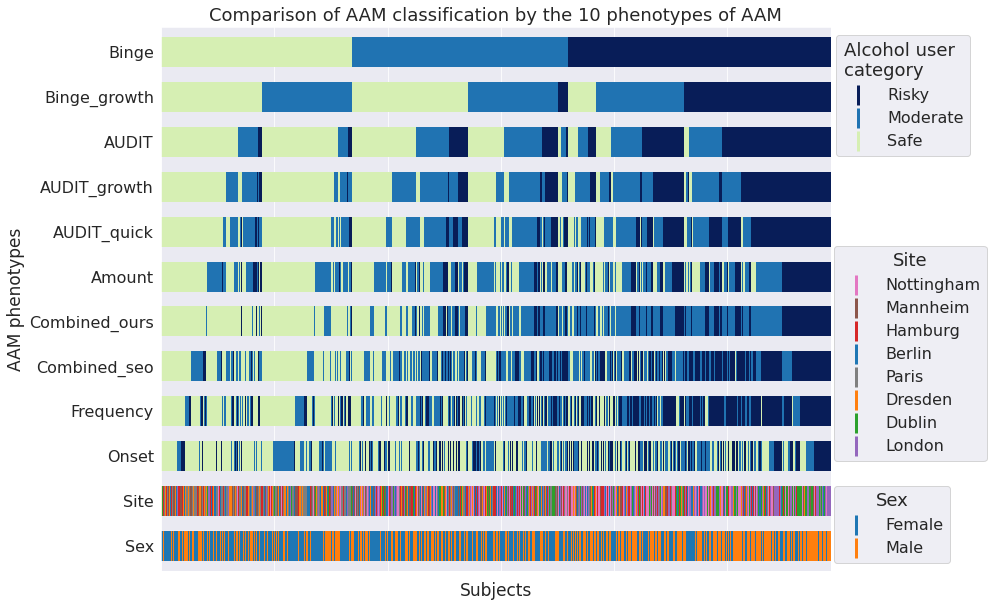

In [5]:
df_all_labels = load_all_labels(TP, 'categorize', exclude_holdout=False).dropna()
confs=['Sex', 'Site']
    
sort_order =  [n for n in sorted(df_all_labels.columns) if "binge" in n.lower()] + \
[n for n in sorted(df_all_labels.columns) if ("binge" not in n.lower()) and (n not in confs)] 
# sort_order = list(reversed(sort_order))
# print(sort_order)
fig, ax = plt.subplots(figsize=(12,len(sort_order)))

plot_subject_classes(df_all_labels, ax, confs=confs,
                     sort_order=sort_order, 
                     title="Comparison of AAM classification by the 10 phenotypes of AAM",
                     lw=30, cmap=plt.cm.YlGnBu)
plt.show()

## Consistency across the 4 ML models  
for the `binge` AAM phenotype

In [6]:
sys.path.insert(1, '../MLpipelines/')
from plotResults import *

In [7]:
LABEL = 'Binge'
MODELS=["SVM-rbf","GB","SVM-lin","LR"]

### holdout results consistent within a model across 7x runs?
with different hyperparameter settings and random_seed

In [8]:
import pandas as pd

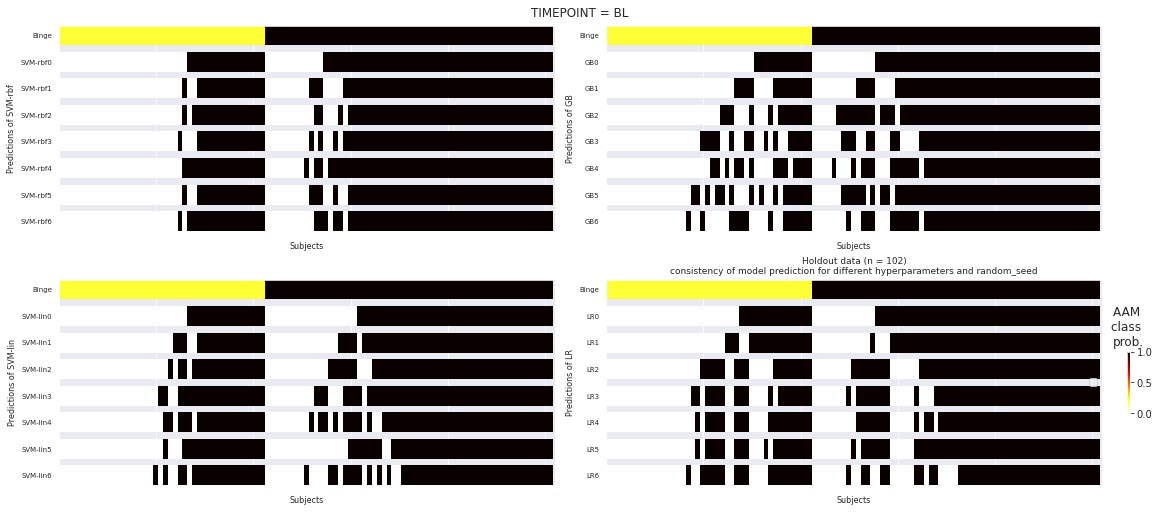

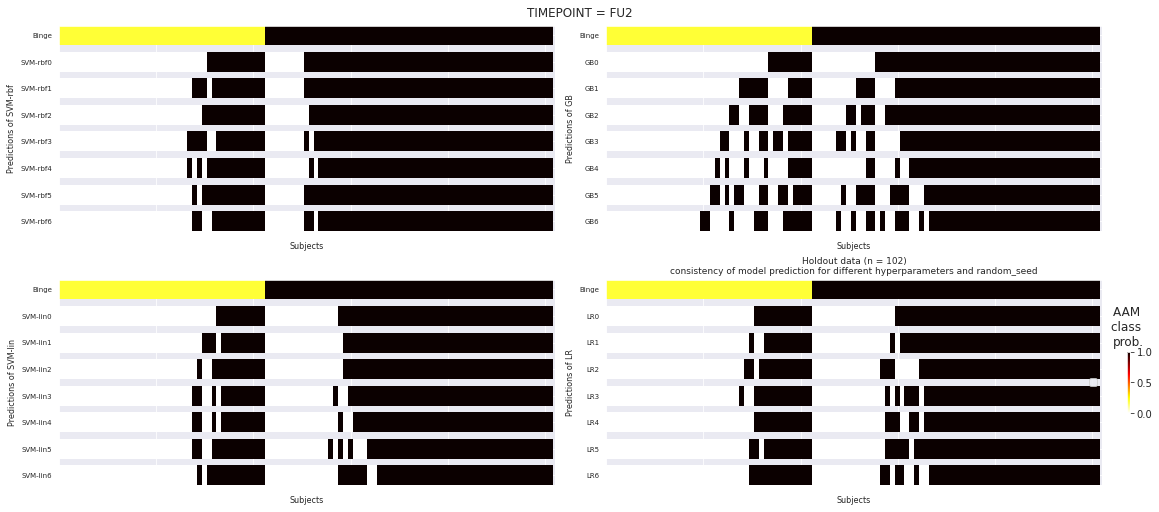

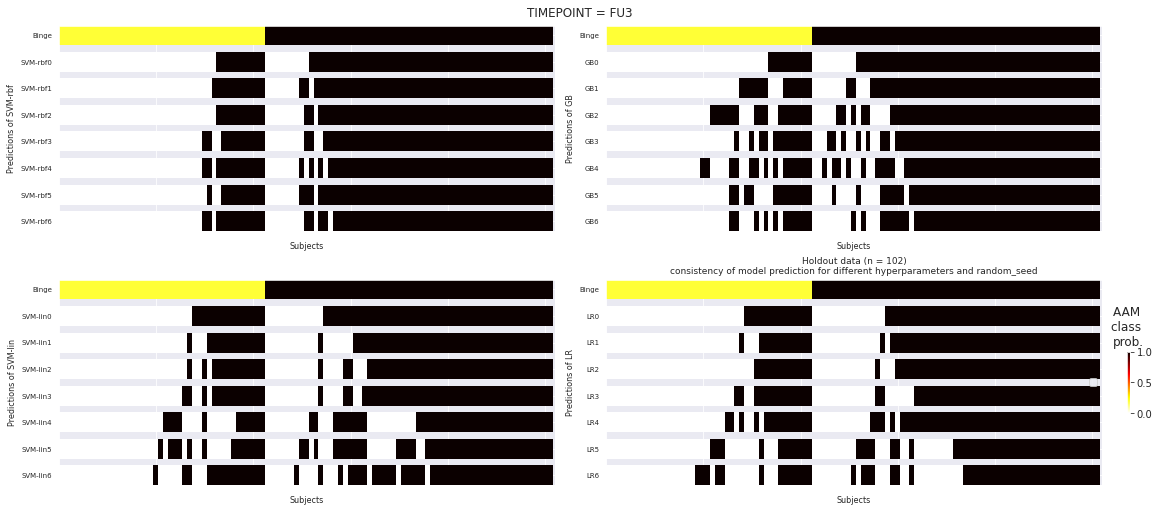

In [9]:
import matplotlib as mpl

USE_PROBS = False

# load the holdout
df_hold = pd.read_csv("../MLpipelines/results/holdout_all-tp-clean_run.csv")
df_hold = df_hold[(df_hold['technique']=='cb') & ~df_hold['i_is_conf'] & ~df_hold['o_is_conf']].drop(columns=["Unnamed: 0"])

for tp, df_hold_tp in df_hold.groupby(['tp']):
    df_model_results = df_all_labels[[LABEL]] # use df_all_labels computed before
    # change the trial ID to reflect model accuracy
    for model, holdout in df_hold_tp.groupby(['model']):
        holdout['trial'].replace({t:i for i,t in enumerate(holdout.sort_values('holdout_roc_auc', ascending=False)['trial'])}, inplace=True)
        for trial, dfi in holdout.groupby(['trial']):
            ids_all = np.array([id_lists for ids in dfi["holdout_ids"] for id_lists in eval(ids)])
            assert ids_all.shape[0] == np.unique(ids_all).shape[0]
            pred_probs_all = np.array([prob_lists for probs in dfi["holdout_probs"] for prob_lists in eval(probs)])[:,1]
            y_pred_all = (pred_probs_all>0.5).astype(int)
            y_true_all = np.array([y_lists for y in dfi["holdout_lbls"] for y_lists in eval(y)])
            assert y_pred_all.shape[0] == y_true_all.shape[0]
            data = pred_probs_all if USE_PROBS else y_pred_all
            data = pd.DataFrame(index=ids_all, data={str(model)+str(trial):data})
            df_model_results = df_model_results.join(data)

    df_model_results = df_model_results.dropna()
    # # plot the correlations between the different models
    # corr = df_model_results.corr()
    # # Fill diagonal and upper half with NaNs
    # mask = np.zeros_like(corr, dtype=bool)
    # mask[np.triu_indices_from(mask)] = True
    # corr[mask] = np.nan
    # (corr.style.background_gradient(axis=None, vmin=0, vmax=1).highlight_null(null_color='#f1f1f1')).set_precision(2)  # Color NaNs grey

    fig, axes = plt.subplots(2,2, figsize=(16,len(df_model_results.columns)//4) , constrained_layout=True)
    fig.suptitle(f"TIMEPOINT = {tp.upper()}")
    cmap = plt.cm.hot_r
    cbar = fig.colorbar(
        mpl.cm.ScalarMappable(norm=mpl.colors.Normalize(vmin=0, vmax=1), cmap=cmap),
        shrink=0.3, location='right')
    cbar.ax.set_title('AAM \nclass \nprob.')
    
    for i,model in enumerate(MODELS):
        dfi = df_model_results[[c for c in df_model_results.columns if (c ==LABEL) or (model.lower() in c.lower())]]
        sort_order = sorted(dfi.columns)
        ax = plot_subject_classes(dfi,
                             ax=np.ravel(axes)[i],
                             sort_order=sort_order,
                             lw=20, fs=7, cmap=cmap,
        title=f"Holdout data (n = {len(dfi)})\nconsistency of model prediction for different hyperparameters and random_seed")
        ax.set_ylabel(f"Predictions of {model}")
        plt.legend([])
    plt.show()

### How does the prediction probabilitiy distribution of the 4 models look?

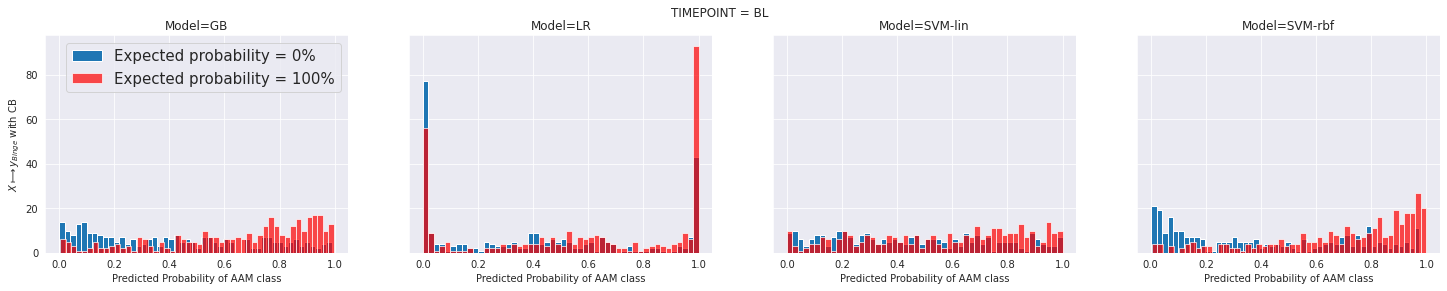

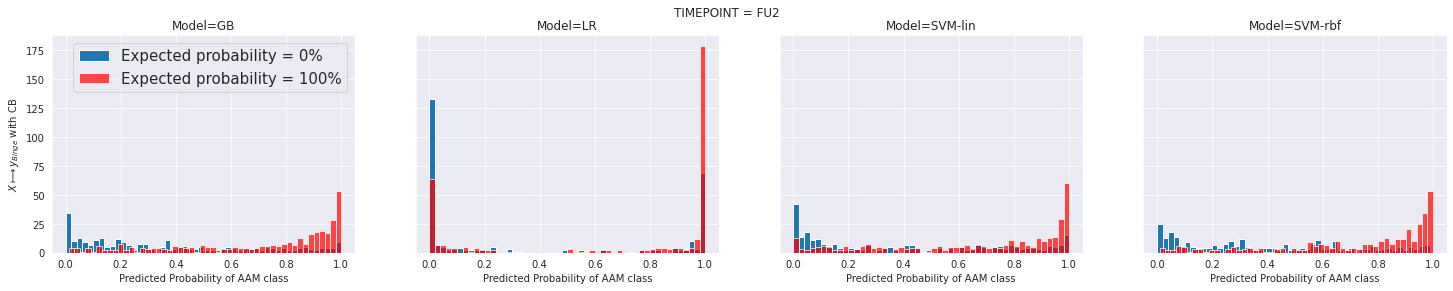

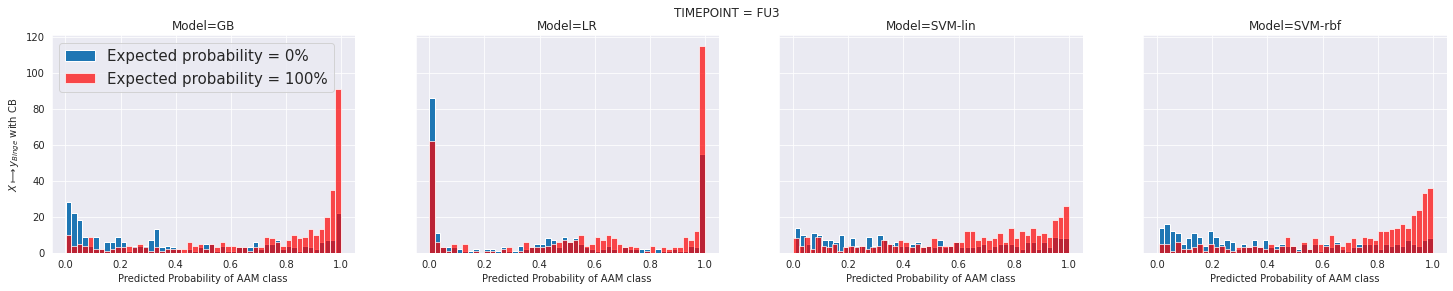

In [11]:
df_hold = pd.read_csv("../MLpipelines/results/holdout_all-tp-clean_run.csv")

for tp, df in df_hold.groupby(['tp']):
    grp_order = ["io", "technique", "model"]
    groups = df.groupby(grp_order)   
    n_models = len(df["model"].unique())
    n_rows = round(len(groups)/n_models)
    fig, axes = plt.subplots(n_rows, n_models, 
                             sharex=True, sharey=True,
                             figsize=(25, n_models*n_rows))
    fig.suptitle(f"TIMEPOINT = {tp.upper()}")
    axes = np.ravel(axes)

    for i, (g, dfi) in enumerate(groups):
        ids_all = np.array([id_lists for ids in dfi["test_ids"] for id_lists in eval(ids)])
        assert ids_all.shape[0] == np.unique(ids_all).shape[0]
        probs_all = np.array([prob_lists for probs in dfi["test_probs"] for prob_lists in eval(probs)])
        y_all = np.array([y_lists for y in dfi["test_lbls"] for y_lists in eval(y)])
        assert probs_all.shape[0] == y_all.shape[0]

        prediction=probs_all[:,1]
        ax = axes[i]
        ax.hist(prediction[y_all==0], bins=50, label='Expected probability = 0%')
        ax.hist(prediction[y_all==1], bins=50, label='Expected probability = 100%', alpha=0.7, color='r')
        ax.set_xlabel('Predicted Probability of AAM class')
        if i%n_models == 0:
            ax.set_ylabel("{} with {}".format(remap_io(dfi.iloc[0]), g[1].upper()))
        if i == 0:
            ax.legend(fontsize=15)
        ax.set_title("Model={}".format(g[-1]))

    plt.show()

### Are all 4 model predictions in agreement with each other?

In [12]:
model_results = load_all_model_preds(df_all_labels)
# [display(tp, tp_results) for tp, tp_results in model_results.items()]

              TP =  FU3


,Binge,SVM-rbf,GB,SVM-lin,LR
Binge,nan,nan,nan,nan,nan
SVM-rbf,0.42,nan,nan,nan,nan
GB,0.41,0.67,nan,nan,nan
SVM-lin,0.29,0.52,0.40,nan,nan
LR,0.27,0.53,0.39,0.67,nan


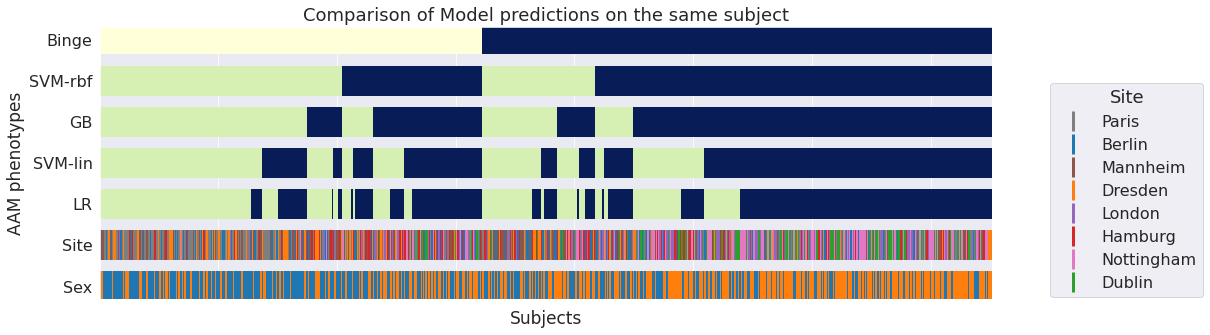

              TP =  FU2


,Binge,SVM-rbf,GB,SVM-lin,LR
Binge,nan,nan,nan,nan,nan
SVM-rbf,0.45,nan,nan,nan,nan
GB,0.42,0.60,nan,nan,nan
SVM-lin,0.36,0.55,0.44,nan,nan
LR,0.31,0.54,0.45,0.88,nan


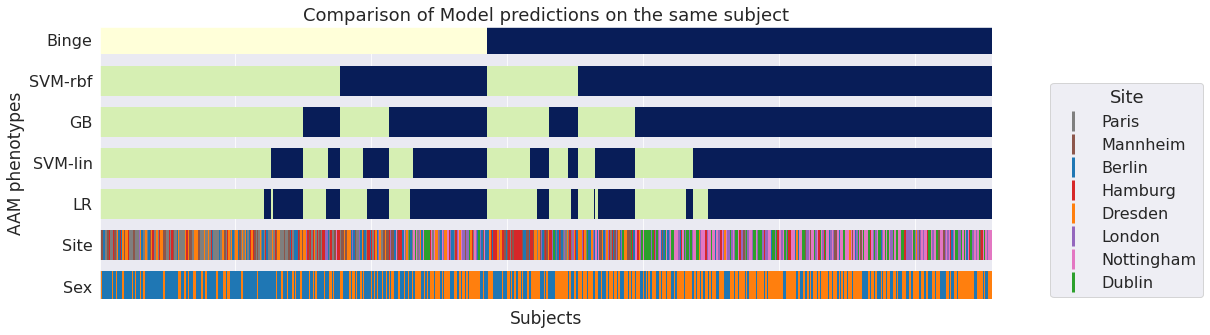

              TP =  BL


,Binge,SVM-rbf,GB,SVM-lin,LR
Binge,nan,nan,nan,nan,nan
SVM-rbf,0.39,nan,nan,nan,nan
GB,0.39,0.60,nan,nan,nan
SVM-lin,0.23,0.55,0.45,nan,nan
LR,0.24,0.54,0.37,0.69,nan


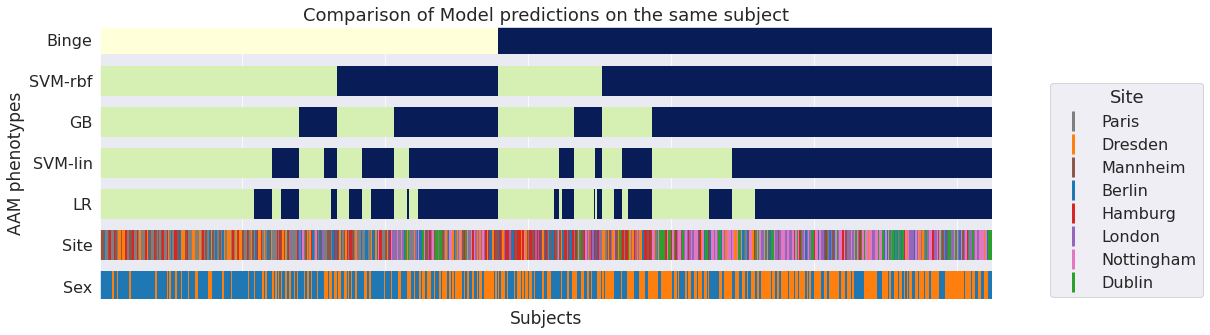

In [13]:
plot_subject_classes_modelwise(model_results, use_probs=False)

### agreement of prediction probabilities

              TP =  FU3


,Binge,SVM-rbf,GB,SVM-lin,LR
Binge,nan,nan,nan,nan,nan
SVM-rbf,0.44,nan,nan,nan,nan
GB,0.42,0.82,nan,nan,nan
SVM-lin,0.28,0.69,0.54,nan,nan
LR,0.25,0.64,0.51,0.81,nan


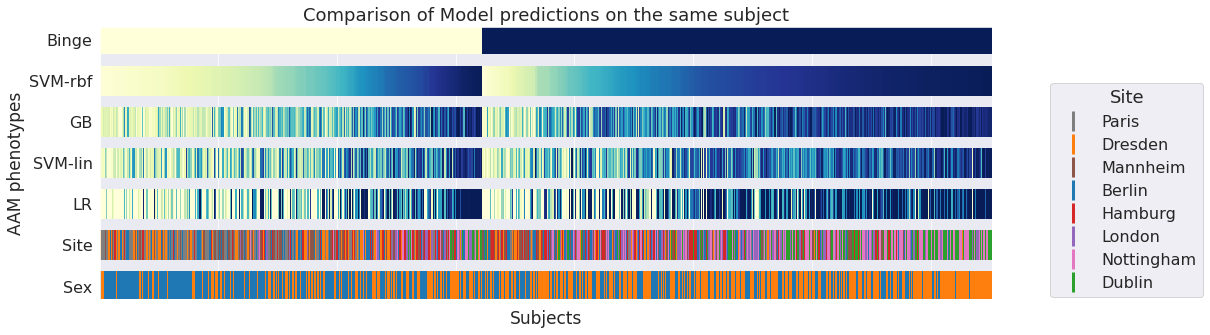

              TP =  FU2


,Binge,SVM-rbf,GB,SVM-lin,LR
Binge,nan,nan,nan,nan,nan
SVM-rbf,0.51,nan,nan,nan,nan
GB,0.47,0.76,nan,nan,nan
SVM-lin,0.39,0.68,0.53,nan,nan
LR,0.36,0.68,0.50,0.92,nan


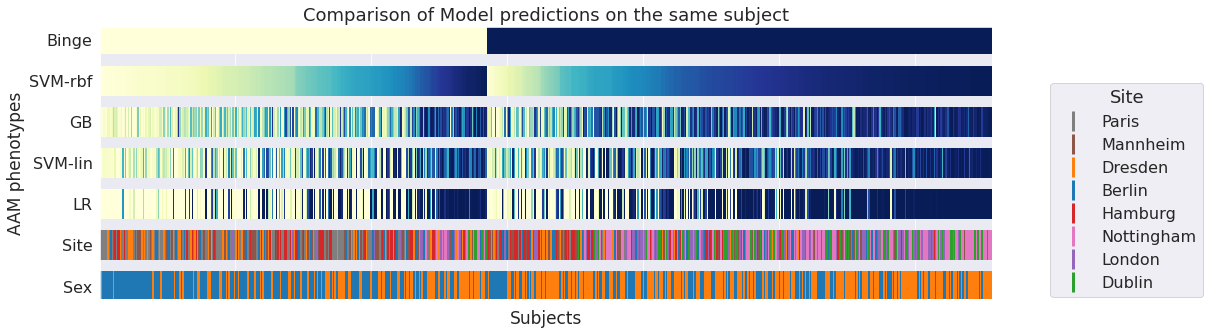

              TP =  BL


,Binge,SVM-rbf,GB,SVM-lin,LR
Binge,nan,nan,nan,nan,nan
SVM-rbf,0.45,nan,nan,nan,nan
GB,0.44,0.75,nan,nan,nan
SVM-lin,0.26,0.69,0.54,nan,nan
LR,0.22,0.60,0.44,0.73,nan


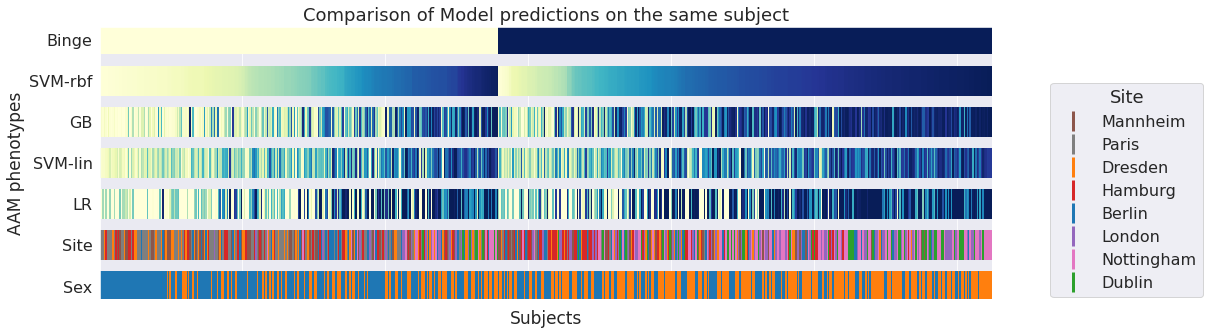

In [14]:
plot_subject_classes_modelwise(model_results, use_probs=True)

<div class="alert alert-block alert-warning">
To do / bugfix:

1.  ~Add holdout set predictions too~
2. run inference on the medium subjects too and see how it looks
3. Visualize the prob. against the Binge continuous variable
</div>

## Performance across sites

### main experiment

              TP =  FU3


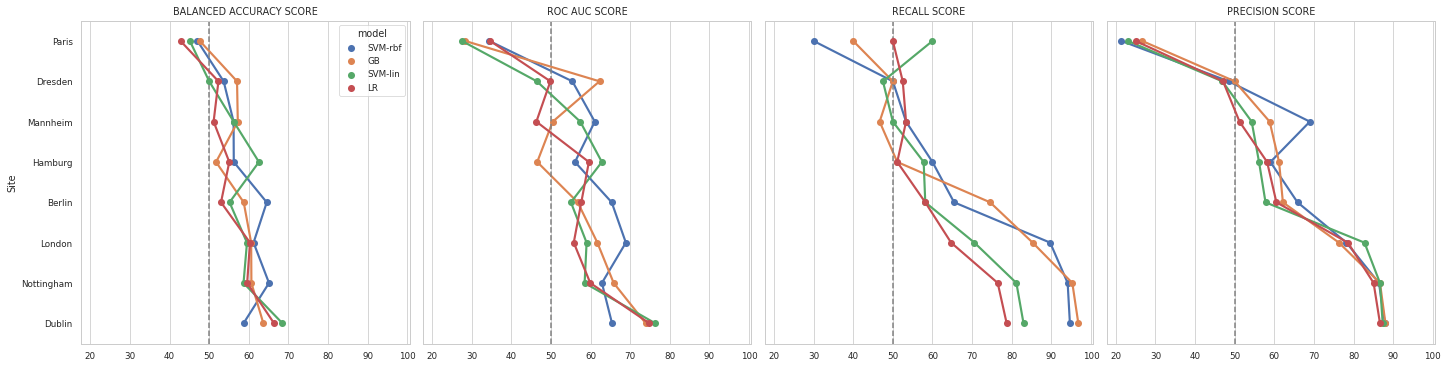

              TP =  FU2


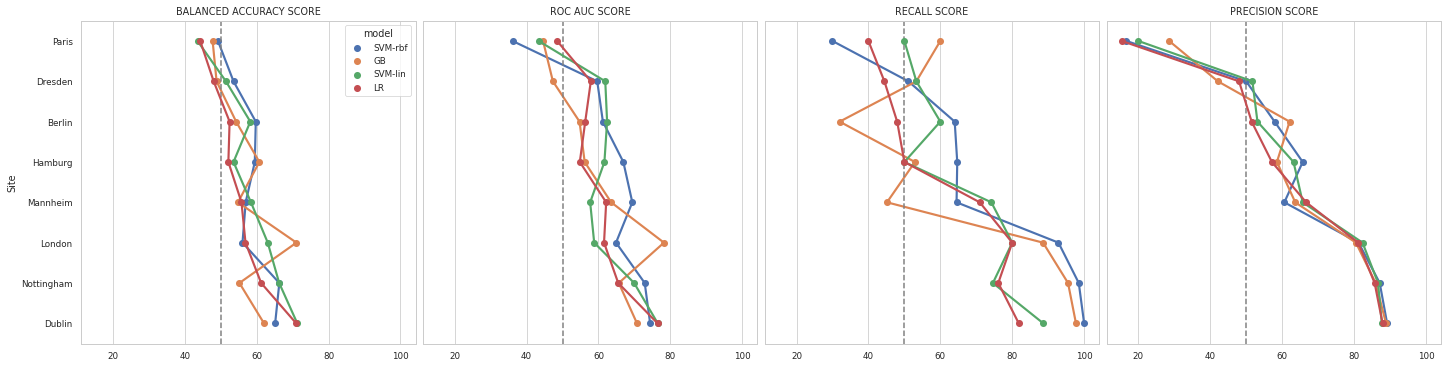

              TP =  BL


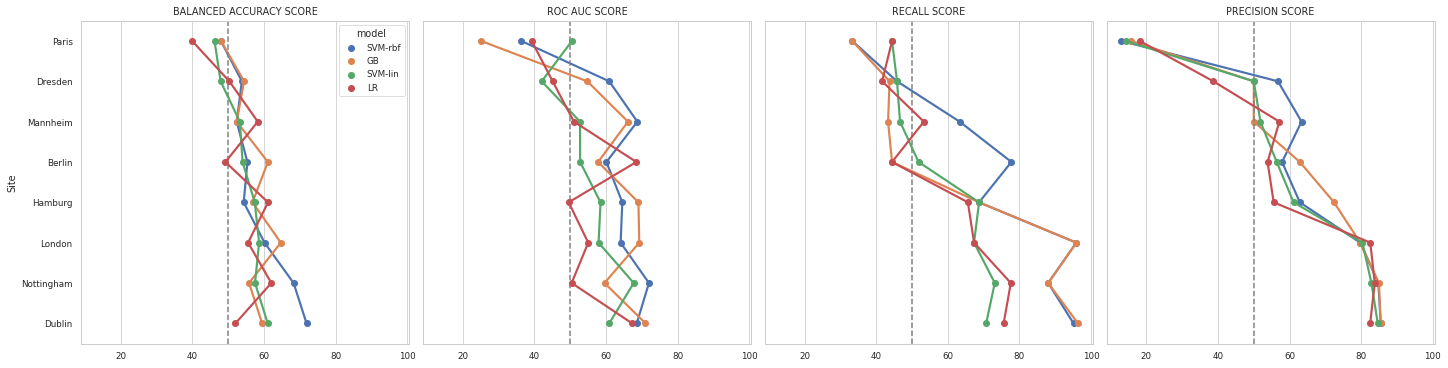

In [15]:
from sklearn.metrics import balanced_accuracy_score, roc_auc_score, recall_score, precision_score
metrics = [balanced_accuracy_score, roc_auc_score, recall_score, precision_score]

for tp, df_model_results in model_results.items():
    print("=======================================\n              TP = ", tp.upper())
    
    sns.set(style='whitegrid', context='paper')
    fig, axes = plt.subplots(1, len(metrics), sharex=True, sharey=True,
                             figsize=(20, 5), constrained_layout=True)

    for i, metric in enumerate(metrics):
        ax = axes[i]
        x = metric.__name__
        data = {}
        for site, dfi in df_model_results.dropna().groupby(['Site']):
            if x=='roc_auc_score':
                scores = {model: metric(dfi[LABEL], dfi[model+'_prob'])*100 for model in MODELS}
            else:
                scores = {model: metric(dfi[LABEL], dfi[model])*100 for model in MODELS}
            data.update({site: scores})
        dfi_computed = pd.DataFrame(data).unstack().reset_index().rename(columns={'level_0':'Site', 'level_1':'model', 0:x})
        sns.pointplot(y="Site", x=x, data=dfi_computed, 
                      order=dfi_computed[["Site", x]].groupby("Site").mean().sort_values(x, ascending=True).index,
                      hue="model", hue_order=MODELS,
                      join=True, palette=sns.color_palette(), 
                      ax=ax)
        ax.axvline(50, lw=1.5, color='gray',linestyle="--")
        ax.set_title(x.upper().replace("_",' '))
        if i>0: ax.set_ylabel("")
        ax.set_xlabel("")
        if i!=0: ax.get_legend().remove()
    plt.show()

### side experiment: _leave-one-site-out_

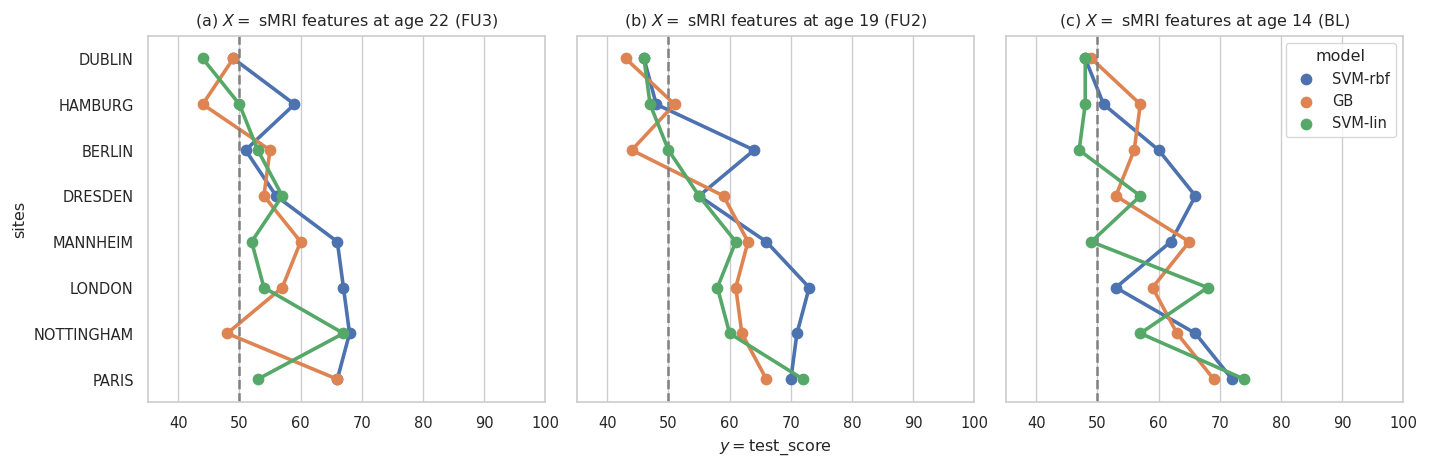

In [16]:
r_path = "fulldata"
df_fulls = [
    (r"(a) $X=$ sMRI features at age 22 (FU3)", pd.read_csv(glob(f"../MLpipelines/results/across_sites/{r_path}-fu3*19a*/*/run.csv")[0])),
    (r"(b) $X=$ sMRI features at age 19 (FU2)", pd.read_csv(glob(f"../MLpipelines/results/across_sites/{r_path}-fu2*19a*/*/run.csv")[0])),
    (r"(c) $X=$ sMRI features at age 14 (BL)",  pd.read_csv(glob(f"../MLpipelines/results/across_sites/{r_path}-bl*19a*/*/run.csv" )[0])),
]
x = "test_score"#'roc_auc'
xlim = [35, 100]

sns.set(style='whitegrid', context='paper')
fig, axes = plt.subplots(1, 3, dpi=120, sharex=True, sharey=True,
                         figsize=(12, 4))

def remap_test_ids_to_site(test_ids):
    test_ids = eval(test_ids)
    # load the information on which site each subject (ID) belong to 
    sub_ids_to_site = pd.read_csv("/ritter/share/data/IMAGEN/IMAGEN_BIDS/participants_BL.csv", usecols=["ID","site"], index_col=["ID"])
    sites = sub_ids_to_site.loc[test_ids]
    return sites["site"].unique()[0]

models = ["SVM-rbf", "GB", "SVM-lin"]#["LR", "SVM-lin", "SVM-rbf", "GB"]

for i, (title, df) in enumerate(df_fulls):
    ax = axes[i]
    
    df = df[df['model'].isin(models)].copy()
    df[x] = df[x].apply(lambda x:round(x*100))
    df["sites"] = df["test_ids"].apply(remap_test_ids_to_site)
    
    sns.pointplot(y="sites", x=x, hue="model", data=df, 
                  order=df[["sites", x]].groupby("sites").mean().sort_values(x, ascending=True).index,
                  hue_order=models,
                  join=True, palette=sns.color_palette(), 
                  ax=ax) 
    
    ax.axvline(50, lw=1.5, color='gray',linestyle="--")
    ax.set_title(title)   
    ax.set_xlim(xlim)
    if i>0: ax.set_ylabel("")
    ax.set_xlabel("")
    if i==1: ax.set_xlabel(r"$y=$"+x)
    if i!=2: ax.get_legend().remove()
        
plt.tight_layout()
plt.show()